In [1]:
#
# Loading libraries
#

import numpy as np

from sklearn.datasets import fetch_openml

from joblib import Parallel, delayed

import scipy.stats

import daz

daz.set_daz()
daz.set_ftz()

np.random.seed(1)

In [2]:
#
# Fetching the dataset from server and scale 
# it for our purpose
#

# Fetch the datasets

# mnist = fetch_openml("mnist_784")

# # Normalize the dataset
# mnist_data = mnist.data.values / np.max(mnist.data.values)

# # Get Targets
# mnist_target = mnist.target.astype(int)

# # Convert labels to binaries
# mnist_label = np.zeros((mnist_data.shape[0], 10))
# for idx in range(mnist_data.shape[0]):
#     mnist_label[idx,int(mnist.target[idx])] = 1

mnist_data = np.load("../mnist_data.np.npy")
mnist_label = np.load("../mnist_label.np.npy")

# Clean memory space of mnist
mnist = None

In [3]:
# Number of middle layer

N_y = int(100)

# Number of training samples 

N_train_sample = int(5000)

In [4]:
def y_of_x(x):
    return 0.5*(x + np.abs(x))

# The activation function for y

def y_of_x(x:np.ndarray, W_E_xy:np.ndarray = None, 
           W_I_yy:np.ndarray = None, noise = None
            ):
    
    if W_E_xy is None:
        return 0.5*(x + np.abs(x))

    if len(x.shape) == 1:
        y = np.zeros((W_E_xy.shape[0]))
    else:
        y = np.zeros((W_E_xy.shape[0], x.shape[1]))

    for t in range(20):
        input4y = np.matmul(W_E_xy, x) / np.sqrt(W_E_xy.shape[1])
        if W_I_yy is not None:
            input4y -= np.matmul(W_I_yy, (y)) / np.sqrt(W_I_yy.shape[1])
        if noise is not None:
            input4y += noise
        y += (-y + np.maximum(input4y, 0)) / np.sqrt(5.0)

    return y

def cal_fit_rate(W_E_xy:np.ndarray, 
                 data_sample:np.ndarray, target_sample:np.ndarray,
                 data_test:np.ndarray, target_test:np.ndarray):

    y = y_of_x(data_sample.transpose(), W_E_xy)

    y_tmp = np.append(y, np.ones((1,y.shape[1])), axis=0)

    y = y_tmp

    W_yz = np.matmul(y, y.transpose())

    W_yz = np.matmul(y.transpose(), np.linalg.pinv(W_yz))

    W_yz = np.matmul(target_sample.transpose(), W_yz)
    
    
    

    y = y_of_x(data_test.transpose(), W_E_xy)

    y_tmp = np.append(y, np.ones((1,y.shape[1])), axis=0)

    y = y_tmp

    z = np.matmul(W_yz, y)

    ans = 1.0 - np.sum(np.heaviside(
                    np.absolute(z.argmax(axis=0) - target_test.argmax(axis=1)) - 0.5
                    , 0)) / float(data_test.shape[0])

    return ans

def update_w(x, w):
    
    w_local = np.copy(w)
    
    x_last = np.zeros(w.shape[1])
    y_last = np.zeros(w.shape[0])
    
    for idx in range(x.shape[0]):
        
        xt = x[idx]
        
#        noise = np.heaviside(np.random.rand(w_local.shape[0]) - 0.95, 0)
        noise = np.random.normal(size=w_local.shape[0])
    
        y = y_of_x(xt, w_local, noise=noise)

        delta_w = np.outer(y, xt)
        
        for i in range(w_local.shape[0]):
            if np.sum(w_local[i]) >= 1.0:
                delta_w[i] = np.zeros_like(delta_w[i])
                
        for i in range(delta_w.shape[1]):
            delta_w[:,i] -= np.mean(delta_w[:,i])

        w_local += 0.02 * delta_w
                    
        for i in range(w_local.shape[1]):
            if np.max(w_local[:,i]) > 1:
                w_local[:,i] /= np.max(w_local[:,i])

        for i in range(w_local.shape[0]):
            if np.max(w_local[i]) < 0:
                w_local[i] = np.zeros_like(w_local[i])
                    
              
    return w_local

In [5]:
from sklearn.decomposition import PCA


def cal_entropy_bin(y, dx):
    
    entropy_record = []
    dx_record = []
    
    non_one_case = 0
    
    dx_record.append(dx)
    y_binned = np.floor((y) / dx)
    y_binned = y_binned.astype(int)

    p = {}

    for yi in y_binned:
        key = tuple(yi)
        p[key] = p.get(key, 0) + 1

    if np.max(list(p.values())) > 1:
        non_one_case += 1

    entropy = 0
    
    pis = np.array([x/np.sum(list(p.values())) for x in p.values()])

    for pi in pis:
        entropy += - (pi) * np.log(pi)

#     entropy +=  y.shape[1]* np.log( dx )
        
    return entropy

def m_info(y, thenum, d=4):
    
    y_max = np.max(y)
    y_min = np.min(y)
    
    if y_max < 1e-20 and y_min < 1e-21:
        y_max = 0.1
        y_min = 0.0
    
    dx = (y_max - y_min) / d 
    
    return cal_entropy_bin(y, dx) - np.mean([cal_entropy_bin(y[thenum == i], dx) for i in set(thenum)])


In [7]:


N_i_s = [x for x in np.arange(0,11)]

while True:
    N_i_s.append(int(N_i_s[-1]*1.5))
    if N_i_s[-1] > N_train_sample:
        N_i_s.pop()
        break

def local_loop():
    #
    # Cutting the dataset to different matices
    #

    # Copy the dataset to training and testing

    N_test = int(mnist_data.shape[0] * 0.1)

    random_list = np.arange(mnist_data.shape[0])
    np.random.shuffle(random_list)

    mnist_target_training = mnist_label[random_list[:N_train_sample]]
    mnist_data_training = mnist_data[random_list[:N_train_sample]]

    mnist_target_testing = mnist_label[random_list[(mnist_data.shape[0]-N_test):]]
    mnist_data_testing = mnist_data[random_list[(mnist_data.shape[0]-N_test):]]

    thenum = np.array([np.argmax(code) for code in mnist_target_training])

    W_E_xy = np.zeros((N_y, mnist_data.shape[1]))

    m_info_record_i = []

    for i in range(len(N_i_s)-1):

        W_E_xy = update_w(mnist_data_training[N_i_s[i]:N_i_s[i+1]], W_E_xy)

        ans = m_info(np.matmul(W_E_xy, mnist_data_training.transpose()).transpose(), thenum, d=2)

        m_info_record_i.append(ans)

        # print(N_i_s[i+1], ans)
        
    return m_info_record_i
    

all_result = Parallel(n_jobs=-1)(delayed(local_loop)() for s in range(10) )
    

In [8]:
all_result = np.array(all_result)
all_result.shape

(10, 25)

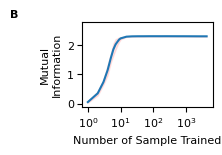

In [34]:
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA

fig = plt.figure(figsize=(5.5/2.525,3.3/2.525))
ax = fig.add_subplot(111)
ax.tick_params('x', labelsize=8, pad=3)
ax.tick_params('y', labelsize=8, pad=2)
ax.set_yticks((0,1,2,3))
ax.set_xlabel("Number of Sample Trained", fontsize=8)
ax.set_ylabel("Mutual\nInformation", fontsize=8)
ax.plot(N_i_s[1:], all_result.mean(axis=0), "-", ms=3, mfc="None")
ax.fill_between(N_i_s[1:], 
                 all_result.mean(axis=0)-all_result.std(axis=0), 
                 all_result.mean(axis=0)+all_result.std(axis=0), color="red", alpha=0.1, zorder=-10)
ax.set_xscale("log")
ax.set_xticks((1e+0,1e+1, 1e+2, 1e+3))
ax.set_ylim((-0.1,2.8))

ax.text(x=-0.55,y=1.05,s="B",weight="bold",fontsize=8, transform=ax.transAxes)

plt.subplots_adjust(left=0.35,
                    bottom=0.3, 
                    right=0.95, 
                    top=0.95, 
                    wspace=0.45, 
                    hspace=0.75)
fig.savefig("Fig04_2mid1.pdf")